- http://localhost:8088/notebooks/git/shopee-product-matching/working/trn0007--b4--cv75.ipynb
- http://localhost:8088/notebooks/git/shopee-product-matching/working/trn0008--b1--max-eps10--cosine--cv75--lb51-65.ipynb

- https://pytorch.org/vision/stable/models.html
- https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2?u=yang-zhang

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

!nvidia-smi


Modules to reload:
all-except-skipped

Modules to skip:

Sun Apr 11 21:12:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    40W / 300W |   9882MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                   

In [2]:
prfxs = ["trn0008", "trn0007","trn0006"] 
imgszes = [224, 512, 512]
enet_types = ["tf_efficientnet_b1_ns", "tf_efficientnet_b4_ns", "tf_efficientnet_b3_ns"]
ckpts = [
    "0_0/checkpoints/epoch=10-step=3640.ckpt",
    "0_0/checkpoints/epoch=23-step=34943.ckpt",
    "0_0/checkpoints/epoch=24-step=9099.ckpt"
]

# setup

In [3]:
HOME = "/data/git/shopee-product-matching"
p_prp = f'{HOME}/output/prep002'

FOLD = 0
FP16 = True

import sys
sys.path.append(f"{HOME}/src")

import pandas as pd
from pl_model import ShpModel
import os
import torch
import numpy as np
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

from final import enet_arcface_FINAL, load_model

from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader


## utils

In [4]:
import numpy as np

def getf1(x, y):
    n = len(np.intersect1d(x, y))
    return 2 * n / (len(x) + len(y))


def getf1s(xs, ys):
    return (getf1(x, y) for x, y in zip(xs, ys))


def meanf1(xs, ys):
    return np.mean(list(getf1s(xs, ys)))


def get_targets(df):
    grp2ids = df.groupby("label_group").posting_id.agg("unique").to_dict()
    targets = df.label_group.map(grp2ids)
    return targets

def preds2pids(preds, pids):
    return [pids[o] for o in preds]


def comb_preds(*preds):
    return (np.unique(np.concatenate(l)) for l in zip(*preds))


# load model

In [5]:
df = pd.read_csv(f'{p_prp}/df_valid.csv')
pids = df.posting_id.values

targets = get_targets(df)

In [6]:
device = torch.device('cuda')
featss = []
for imdl in range(len(prfxs)):
    prfx = prfxs[imdl]
    imgsz = imgszes[imdl]
    enet_type = enet_types[imdl]
    ckpt = ckpts[imdl]
    shpmodel = ShpModel.load_from_checkpoint(f'{HOME}/output/{prfx}/tensorboard_csv/{ckpt}')
    out_dim = shpmodel.num_classes
    
    
    model = enet_arcface_FINAL(enet_type, out_dim=out_dim).to(device)
    model = load_model(model, shpmodel)
    model = model.to(device)
    
    
    
    tfms_trn, tfms_val = get_transforms(imgsz)
    ds = ShopeeDataset(df, mode="test", transform=tfms_val)
    dl = DataLoader(ds,
                batch_size=32,
                num_workers=8,
                pin_memory=True,
            )

    feats = np.zeros((len(ds), 512))
    i = 0
    for dat in tqdm(dl):
        with torch.no_grad():
            dat = dat.to(device)
            feat,_ = model(dat)
            l = len(feat)
            feats[i : i + l, :] = feat.cpu().detach().numpy()
            i += l
            
    featss.append(feats)
    

100%|██████████| 161/161 [00:36<00:00,  4.38it/s]


In [7]:
len(featss)

3

# inference

In [8]:
from cuml.neighbors import NearestNeighbors
import numpy as np
import torch.nn.functional as F


N_NBRS = 50
CHUNK = 1024 * 4


def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS, metric="cosine")
    nnmdl.fit(feats)
    return nnmdl


def get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype="float")
    idx = np.zeros((n, n_nbrs), dtype="int")
    n_chunks = len(feats) // sz_chunk
    if len(feats) % sz_chunk != 0:
        n_chunks += 1
    for j in tqdm(range(n_chunks)):
        a = j * sz_chunk
        b = (j + 1) * sz_chunk
        b = min(b, len(feats))
        dists_, idx_ = nnmdl.kneighbors(
            feats[
                a:b,
            ]
        )
        dists[a:b] = dists_
        idx[a:b] = idx_
    return dists, idx


def get_nbrs(feats, n_nbrs=N_NBRS, sz_chunk=CHUNK):
    nnmdl = mk_nnmdl(feats, n_nbrs)
    dists, idx = get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk)
    return dists, idx


def get_preds_by_thrsh(dists, idx, thrsh):
    preds = (ind[dst < thrsh] for dst, ind in zip(dists, idx))
    return preds


def find_best(dists, idx, thrshes=np.linspace(0.,1.,num=21)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    res = {'f1_best': f1_best, 
           'thrsh_best': thrsh_best, 
           'preds_best': preds_best, 
           'thrshes': thrshes, 
           'f1_lst': f1_lst}
    return res

In [16]:
len(featss)

3

In [9]:
feats_conc = np.concatenate(featss, 1)
feats_conc = F.normalize(torch.tensor(feats_conc))
feats_conc = feats_conc.numpy()

In [10]:
feats_conc.shape

(5135, 1536)

In [11]:
nbrs = get_nbrs(feats_conc)

100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


In [12]:
dists, idx = nbrs
res = find_best(dists, idx)
print(f"{res['f1_best']:.3f}, {res['thrsh_best']:.2f} ")

100%|██████████| 21/21 [00:04<00:00,  4.27it/s]

0.778, 0.60 


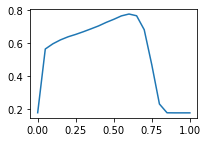

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(res['thrshes'], res['f1_lst'])  
plt.show()

# fin

In [14]:
!nvidia-smi

Sun Apr 11 21:14:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   46C    P0    41W / 300W |   9066MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  